In [1]:
import os
os.chdir('/home/jknize/main/repo/CSC578/detectron2')
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Simple ResNet object detection training using provided backbone from ImageNet pre-train

In [2]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
# DatasetCatalog.remove("coco_train_subset")
# MetadataCatalog.remove("coco_train_subset")
register_coco_instances("coco_train_dog", {}, "../datasets/coco/annotations/dog_instances_train2017.json", "../datasets/coco/train2017_dog")
# DatasetCatalog.remove("coco_val_subset")
# MetadataCatalog.remove("coco_val_subset")
register_coco_instances("coco_val_dog", {}, "../datasets/coco/annotations/dog_instances_val2017.json", "../datasets/coco/val2017_dog")

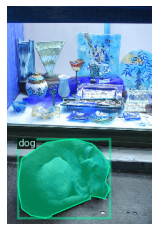

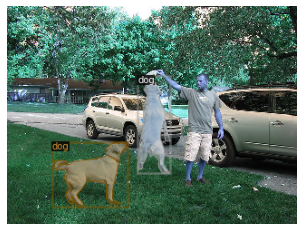

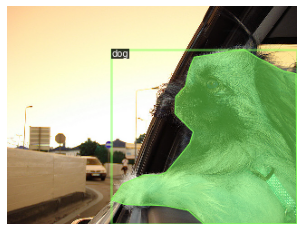

In [4]:
from detectron2.utils.visualizer import Visualizer
import random
import cv2
import matplotlib.pyplot as plt

my_dataset_metadata = MetadataCatalog.get("coco_train_dog")
my_dataset_metadata.thing_classes = ["dog"]
dataset_dicts = DatasetCatalog.get("coco_train_dog")

# Visualize 3 random images
for d in random.sample(dataset_dicts, 3):
    file_name = d['file_name']
    img = cv2.imread(d["file_name"]) 
    if img is None:
        print(f"Failed to load image: {d['file_name']}")
        continue 
     
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)  # Draw annotations on the image
    output_image = out.get_image()[:, :, ::-1]  # Convert back from BGR to RGB for matplotlib
    plt.imshow(output_image)
    plt.axis("off")  # Turn off axis
    plt.show()

Fine-tune weights to our COCO subset

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
import torch

# load simple ResNet-50 model without FPN
cfg = get_cfg()
cfg.merge_from_file("configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml") #ImageNet pre-trained
cfg.OUTPUT_DIR = "knize/output/dog"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 

cfg.DATASETS.TRAIN = ("coco_train_dog",)
cfg.DATASETS.TEST = ("coco_val_dog",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# solver config (guesses)
# 4385 dog images to train on
cfg.SOLVER.IMS_PER_BATCH = 8
# cfg.SOLVER.BASE_LR = 0.00025 # just going to try to use the base lr
cfg.SOLVER.MAX_ITER = 1700 # about 3 epochs
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
# cfg.SOLVER.STEPS = [] # disable learning decay

# run on GPU
cfg.MODEL.DEVICE = 'cuda'

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.model.to(cfg.MODEL.DEVICE)
# inputs = inputs.to(cfg.MODEL.DEVICE)

trainer.train()


[11/10 13:18:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


[11/10 13:18:56 d2.engine.train_loop]: Starting training from iteration 0
[11/10 13:19:08 d2.utils.events]:  eta: 0:00:43  iter: 19  total_loss: 1.511  loss_cls: 0.7798  loss_box_reg: 0.02382  loss_rpn_cls: 0.656  loss_rpn_loc: 0.04269    time: 0.5870  last_time: 0.5200  data_time: 0.0275  last_data_time: 0.0026   lr: 4.7703e-05  max_mem: 14563M
[11/10 13:19:19 d2.utils.events]:  eta: 0:00:32  iter: 39  total_loss: 1.458  loss_cls: 0.4987  loss_box_reg: 0.1014  loss_rpn_cls: 0.5951  loss_rpn_loc: 0.1139    time: 0.5659  last_time: 0.5894  data_time: 0.0056  last_data_time: 0.0036   lr: 9.7653e-05  max_mem: 14563M
[11/10 13:19:30 d2.utils.events]:  eta: 0:00:21  iter: 59  total_loss: 1.012  loss_cls: 0.293  loss_box_reg: 0.1592  loss_rpn_cls: 0.4597  loss_rpn_loc: 0.04752    time: 0.5636  last_time: 0.5385  data_time: 0.0043  last_data_time: 0.0051   lr: 0.0001476  max_mem: 14563M
[11/10 13:19:42 d2.utils.events]:  eta: 0:00:10  iter: 79  total_loss: 1.034  loss_cls: 0.3296  loss_box_re

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# evaluate performance of trained subset model
cfg.MODEL.WEIGHTS = "knize/output/dog/model_final.pth"

trainer.model.eval()

evaluator = COCOEvaluator("coco_val_dog", ("bbox",), False, output_dir="./knize/output/subset/trained")
val_loader = build_detection_test_loader(cfg, "coco_val_dog")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

[11/10 13:17:29 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[11/10 13:17:30 d2.data.datasets.coco]: Loaded 3196 images in COCO format from ../datasets/coco/annotations/filtered_instances_val2017_2.json
[11/10 13:17:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/10 13:17:30 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/10 13:17:30 d2.data.common]: Serializing 3196 elements to byte tensors and concatenating them all ...
[11/10 13:17:30 d2.data.common]: Serialized dataset takes 9.22 MiB
[11/10 13:17:30 d2.evaluation.evaluator]: Start inference on 3196 batches
[11/10 13:17:33 d2.evaluation.evaluator]: Inference done 11/3196. Dataloading: 0.0012 s/iter. Inference: 0.2601 s/iter. Eval: 0.0003 s/iter. Total: 0.2616 s/iter. ETA=0:13:53
[11/10 13:17:38 d2.evaluat

KeyboardInterrupt: 

In [14]:
print(os.getcwd())

/home/jknize/main/repo/CSC578/detectron2
